# Latent Space Exploration for SDF Tower Shapes

This tutorial demonstrates how to use an **auto-decoder architecture** to learn a continuous latent space representation of 2D tower shapes defined by Signed Distance Fields (SDFs). 

## Auto-Decoder Architecture

The auto-decoder is a neural architecture that learns both:
- **Latent codes**: Compact representations for each shape in the dataset
- **Decoder network**: Maps from latent space to shape geometry

Unlike traditional autoencoders, there's no encoder - latent codes are learned directly as trainable parameters.

**Key Components:**
- Input: Concatenated [latent_code + spatial_coordinate] 
- Output: SDF value at that coordinate
- Training: Jointly optimize latent codes and decoder weights

**Tutorial Workflow:**
1. Load SDF tower shape data
2. Implement auto-decoder architecture  
3. Train the model to learn latent representations
4. Explore the continuous latent space
5. Export for interactive path creation

In [20]:
# Import required libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import tensorflow as tf
from tensorflow import keras
from keras import layers
import os
import json
from datetime import datetime

def create_sdf_colormap():
    """Create consistent grayscale colormap for SDF visualization"""
    from matplotlib.colors import LinearSegmentedColormap
    
    colors_list = ['black', 'gray', 'white']
    cmap = LinearSegmentedColormap.from_list('sdf_grayscale', colors_list, N=256)
    norm = colors.Normalize(vmin=-0.1, vmax=0.1, clip=True)
    return cmap, norm

# Global visualization settings
SDF_CMAP, SDF_NORM = create_sdf_colormap()

def plot_sdf(sdf_data, title="SDF", show_colorbar=False):
    """Plot SDF with consistent visualization"""
    plt.imshow(sdf_data, cmap=SDF_CMAP, norm=SDF_NORM)
    plt.title(title)
    if show_colorbar:
        plt.colorbar(label='SDF Value')
    plt.axis('off')

## Step 1: Load Tower Shape Data

We'll load scalar field data representing different tower shapes. Each shape is defined by an SDF (Signed Distance Field) where:
- **Negative values**: Inside the shape
- **Zero**: On the boundary  
- **Positive values**: Outside the shape

Grid dimensions: 128 × 128
Found 5 tower shapes
Scalar field keys: ['scalar_field1_data', 'scalar_field2_data', 'scalar_field3_data', 'scalar_field4_data', 'scalar_field5_data']
Training data: 5 shapes with 16384 points each


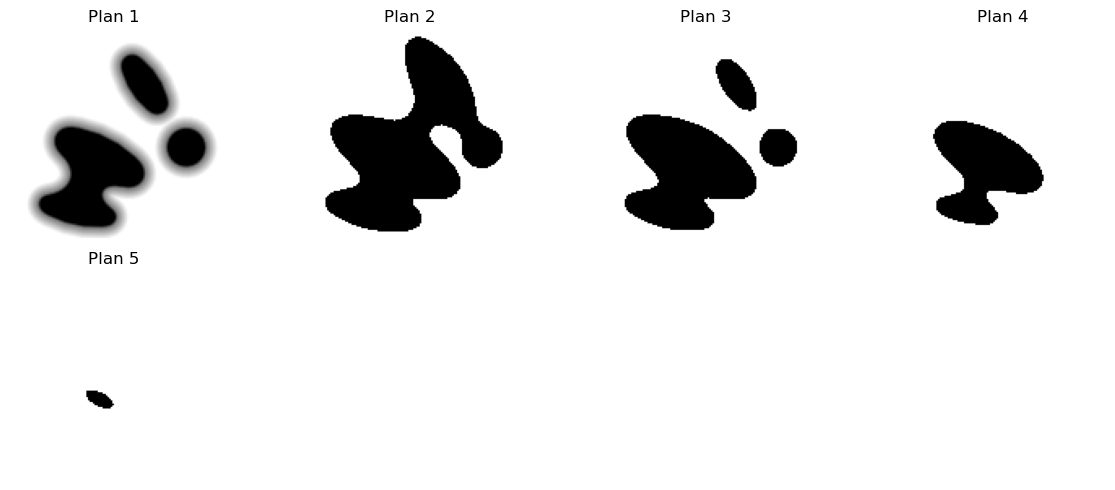

In [21]:
# Load tower shape data from JSON'
with open('data.json', 'r') as f:
    data = json.load(f)

# Extract grid information - these are integers, not lists
x_count = int(data['scalar_field_XCount'])
y_count = int(data['scalar_field_YCount'])

print(f"Grid dimensions: {x_count} × {y_count}")

# Find all scalar field data (tower shapes)
# Updated to handle both old format (scalar_field_00, scalar_field_01) 
# and new format (scalar_field1_data, scalar_field2_data)
scalar_field_keys = []
for key in data.keys():
    # Check for old format: scalar_field_XX (where XX is a number)
    if (key.startswith('scalar_field_') and 
        key not in ['scalar_field_XCount', 'scalar_field_YCount', 'scalar_field_XSize', 'scalar_field_YSize']):
        if isinstance(data[key], list) and len(data[key]) == x_count * y_count:
            scalar_field_keys.append(key)
    # Check for new format: scalar_fieldN_data (where N is a number)
    elif (key.startswith('scalar_field') and key.endswith('_data')):
        if isinstance(data[key], list) and len(data[key]) == x_count * y_count:
            scalar_field_keys.append(key)

scalar_field_keys.sort()
print(f"Found {len(scalar_field_keys)} tower shapes")
print(f"Scalar field keys: {scalar_field_keys}")

# Load and reshape scalar fields
scalar_fields = []
for field_name in scalar_field_keys:
    field_data = np.array(data[field_name])
    field_2d = field_data.reshape(y_count, x_count, order='F') 
    scalar_fields.append(field_2d)

sdf_data = np.array(scalar_fields)
num_shapes = len(sdf_data)

# Create normalized coordinate grid [-1, 1] for training
x_coords = np.linspace(-1, 1, x_count, dtype=np.float32)
y_coords = np.linspace(-1, 1, y_count, dtype=np.float32)
X, Y = np.meshgrid(x_coords, y_coords)
coords_flat = np.stack([X.flatten(), Y.flatten()], axis=1).astype(np.float32)

# Flatten SDF data for efficient training
sdf_data_flat = sdf_data.reshape(num_shapes, -1).astype(np.float32)

print(f"Training data: {num_shapes} shapes with {sdf_data_flat.shape[1]} points each")

# Visualize the tower shapes
if num_shapes > 0:
    cols = min(num_shapes, 4)
    rows = (num_shapes + cols - 1) // cols
    
    plt.figure(figsize=(cols * 3, rows * 2.5))
    for i in range(num_shapes):
        plt.subplot(rows, cols, i + 1)
        plot_sdf(sdf_data[i], f"Plan {i+1}")
    plt.tight_layout()
    plt.show()

In [22]:
# Preprocess SDF data: clamp values outside [-0.1, 0.1] to -1 or 1 based on sign
def preprocess_sdf(sdf_array, threshold=0.1):
    """
    Preprocess SDF data to only keep values within [-threshold, threshold]
    Values outside this range are clamped to -1 or 1 based on their sign
    
    Args:
        sdf_array: numpy array of SDF values
        threshold: threshold for clamping (default: 0.1)
    
    Returns:
        Preprocessed SDF array
    """
    processed_sdf = sdf_array.copy()
    
    # Clamp positive values > threshold to 1
    processed_sdf[processed_sdf > threshold] = 1.0
    
    # Clamp negative values < -threshold to -1  
    processed_sdf[processed_sdf < -threshold] = -1.0
    
    return processed_sdf

print("🔧 Preprocessing SDF data...")

# Apply preprocessing to the SDF data
sdf_data_original = sdf_data.copy()  # Keep original for comparison
sdf_data = preprocess_sdf(sdf_data, threshold=0.1)

# Update flattened data for training
sdf_data_flat = sdf_data.reshape(num_shapes, -1).astype(np.float32)

# Count values in each range
original_in_range = np.sum((sdf_data_original >= -0.1) & (sdf_data_original <= 0.1))
original_total = sdf_data_original.size
processed_in_range = np.sum((sdf_data >= -0.1) & (sdf_data <= 0.1))


🔧 Preprocessing SDF data...


## Step 2: Auto-Decoder Architecture

The auto-decoder consists of:

**1. Learnable Latent Codes**: One vector per shape (trainable parameters)
**2. Decoder Network**: Neural network that maps (latent_code + coordinate) → SDF_value

This architecture learns to embed shapes in a continuous latent space where:
- Similar shapes are close together
- Interpolation between points creates smooth shape transitions
- New shapes can be generated by sampling from the space

In [23]:
# Auto-decoder hyperparameters
LATENT_DIM = 2      # 2D latent space for visualization
COORD_DIM = 2       # 2D spatial coordinates (x, y)
INPUT_DIM = LATENT_DIM + COORD_DIM  # Combined input size
NUM_SHAPES = num_shapes

def create_decoder():
    """
    Decoder Network Architecture
    
    Input: [latent_code (2D) + coordinate (2D)] = 4D vector
    Output: SDF value at that coordinate
    
    The network learns to decode latent representations into geometry
    """
    decoder = keras.Sequential([
        layers.Input(shape=(INPUT_DIM,)),
        
        # Deep network to capture complex shape relationships
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'), 
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'), 
        layers.Dense(128, activation='relu'), 
        
        # Output single SDF value
        layers.Dense(1, activation='linear')
    ])
    return decoder

# Create decoder network
decoder = create_decoder()
print("Decoder Architecture:")
decoder.summary()

Decoder Architecture:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                 │ (None, 128)            │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 83,329 (325.50 KB)

 Trainable params: 83,329 (325.50 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# Initialize learnable latent codes for each tower shape
def initialize_latent_codes(num_shapes, latent_dim):
    """Initialize latent codes with boundary bias for better exploration"""
    codes = []
    for i in range(num_shapes):
        # Generate random direction and bias towards boundaries
        direction = np.random.randn(latent_dim)
        direction = direction / np.linalg.norm(direction)
        
        # Use beta distribution to bias towards edges  
        magnitude = np.random.beta(4.0, 1.0) * 0.9
        code = direction * magnitude
        
        # Random sign flips for full quadrant coverage
        for j in range(latent_dim):
            if np.random.random() < 0.5:
                code[j] = -code[j]
        
        codes.append(code)
    
    return np.array(codes, dtype=np.float32)

# Create trainable latent codes
initial_codes = initialize_latent_codes(NUM_SHAPES, LATENT_DIM)
latent_codes = tf.Variable(initial_codes, trainable=True, name="latent_codes")

print("Initialized latent codes:")
for i, code in enumerate(initial_codes):
    print(f"Tower {i+1}: [{code[0]:.3f}, {code[1]:.3f}]")

# Training setup with constant learning rate
learning_rate = 0.001
optimizer = keras.optimizers.Adam(learning_rate=learning_rate)
loss_fn = keras.losses.MeanSquaredError()
epochs = 2000
batch_size = 512

@tf.function
def train_step(shape_idx, coord_batch, sdf_batch):
    """Training step: optimize both latent codes and decoder weights"""
    with tf.GradientTape() as tape:
        # Get latent code for current shape
        shape_latent = tf.gather(latent_codes, [shape_idx])
        
        # Broadcast to match coordinate batch size
        batch_size_actual = tf.shape(coord_batch)[0]
        batch_latent_codes = tf.tile(shape_latent, [batch_size_actual, 1])
        
        # Concatenate latent codes with coordinates
        decoder_input = tf.concat([batch_latent_codes, coord_batch], axis=1)
        
        # Predict SDF values
        predicted_sdf = decoder(decoder_input)
        target_sdf = tf.expand_dims(sdf_batch, -1)
        
        # Compute reconstruction loss
        loss = loss_fn(target_sdf, predicted_sdf)
    
    # Update both latent codes and decoder weights
    trainable_vars = [latent_codes] + decoder.trainable_variables
    gradients = tape.gradient(loss, trainable_vars)
    optimizer.apply_gradients(zip(gradients, trainable_vars))
    
    return loss

print("Training setup complete!")
print(f"Learning rate: {learning_rate}")

Initialized latent codes:
Tower 1: [-0.600, 0.231]
Tower 2: [-0.692, 0.303]
Tower 3: [0.683, 0.226]
Tower 4: [-0.569, -0.005]
Tower 5: [0.670, 0.439]
Training setup complete!
Learning rate: 0.001


🎯 Training Auto-Decoder...
Epoch 1/2000, Loss: 0.731396


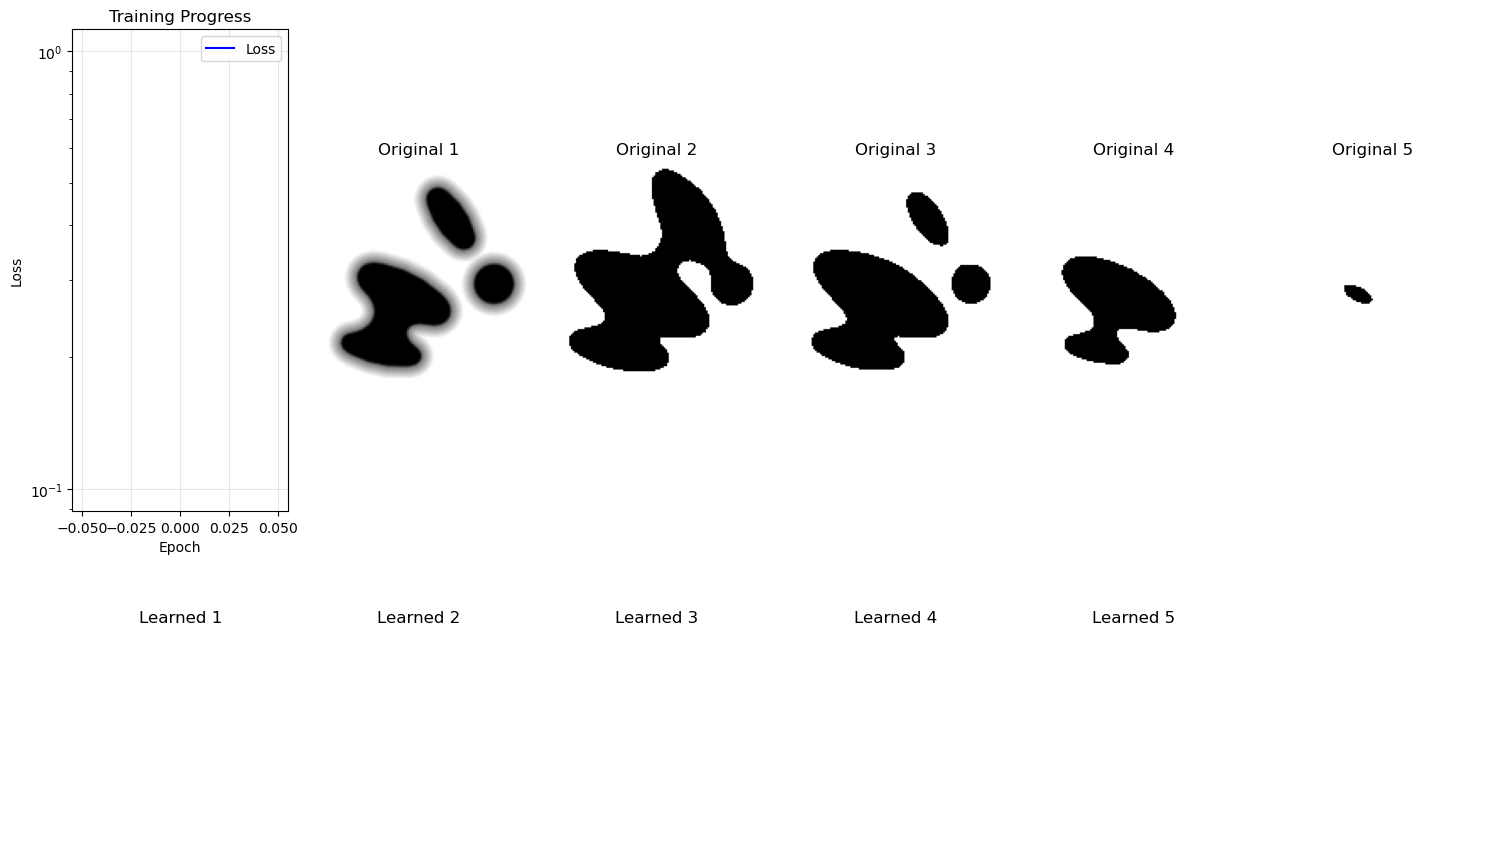

Epoch 200/2000, Loss: 0.082837


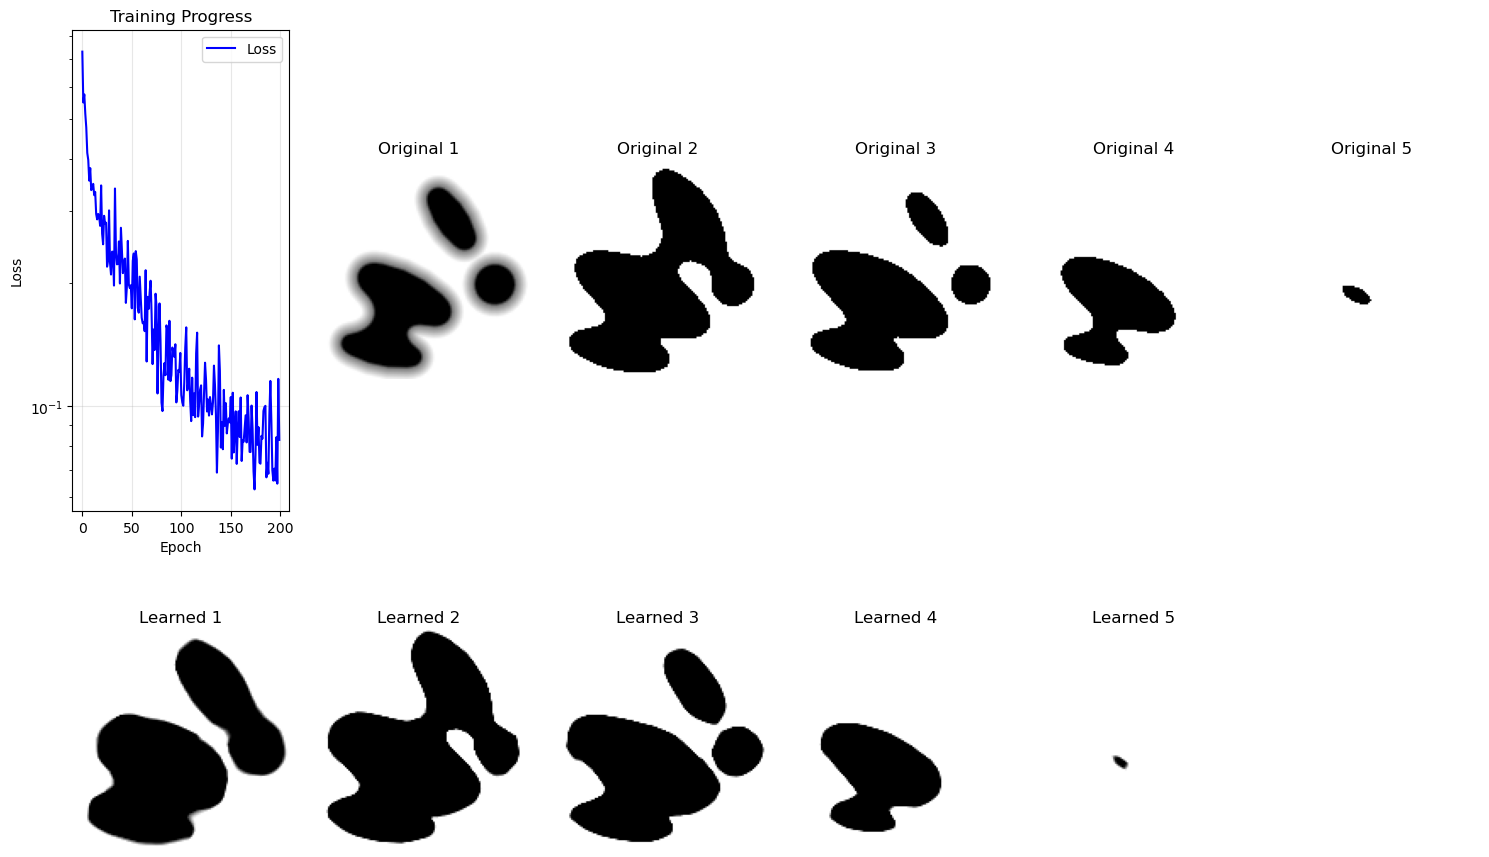

Epoch 400/2000, Loss: 0.059648


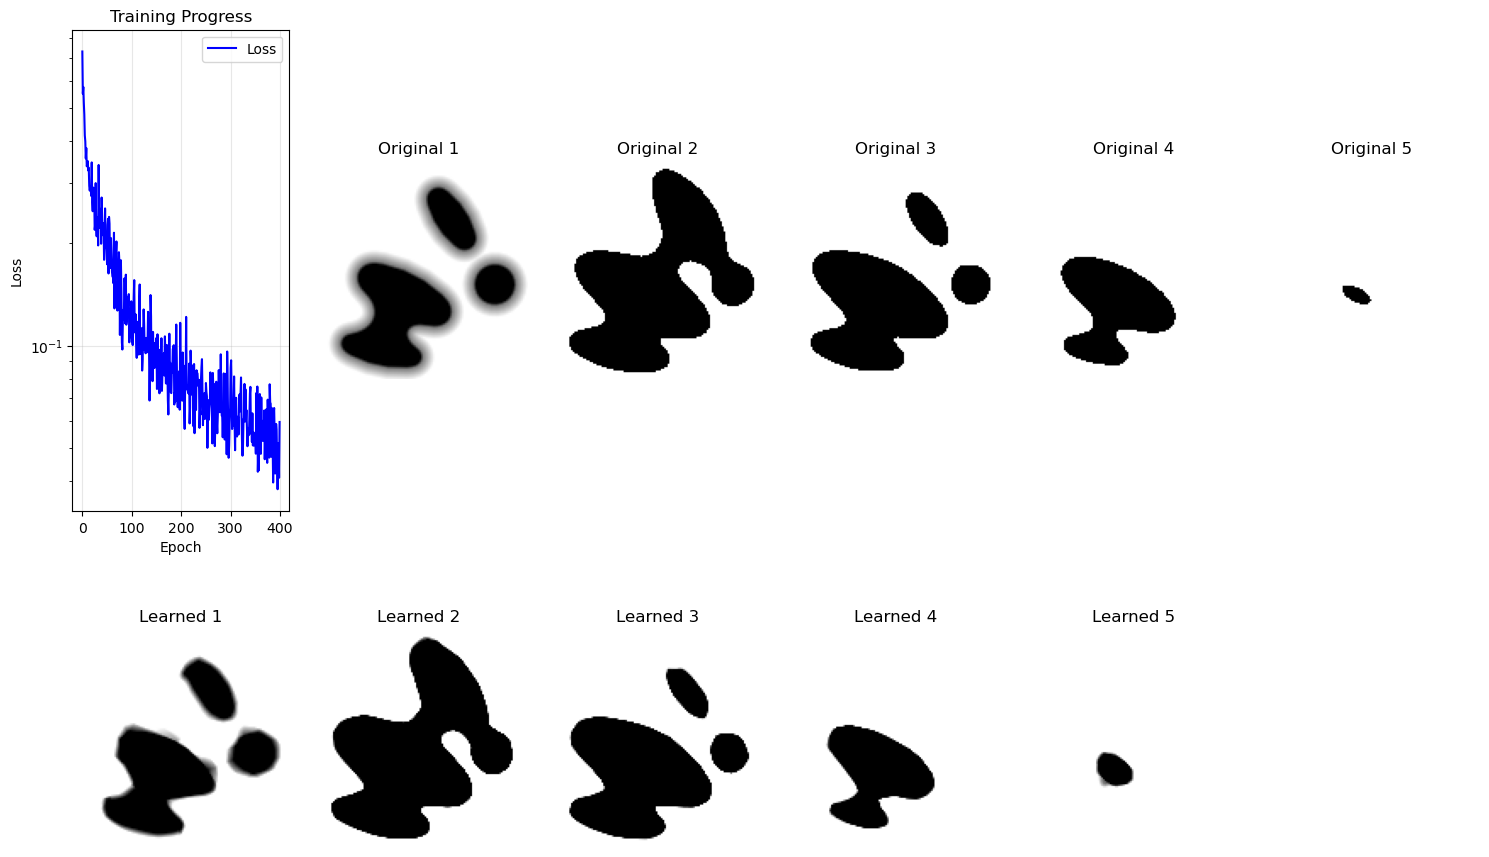

Epoch 600/2000, Loss: 0.033481


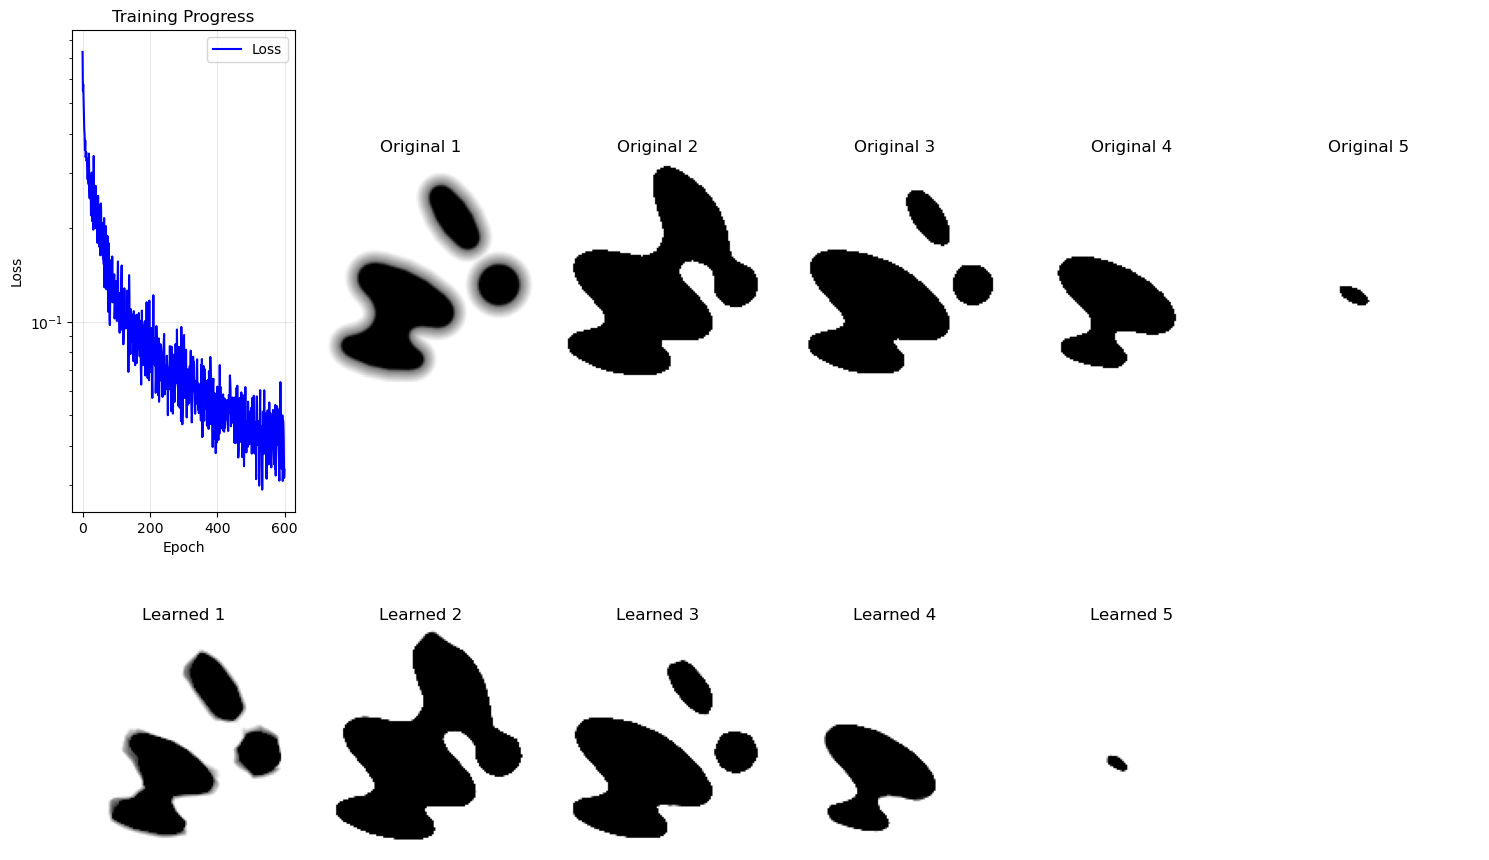

Epoch 800/2000, Loss: 0.034139


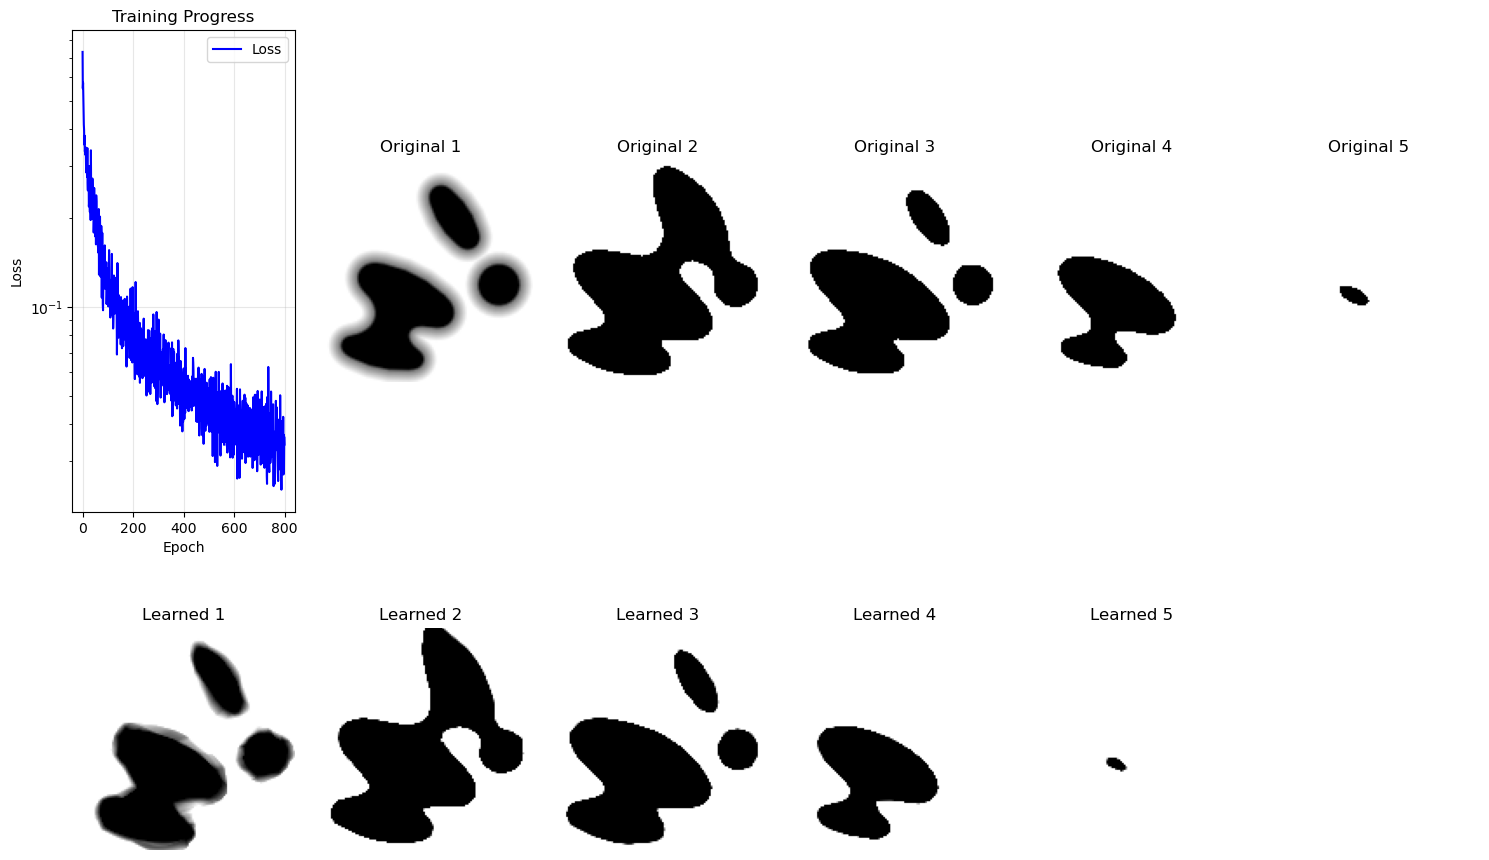

Epoch 1000/2000, Loss: 0.026128


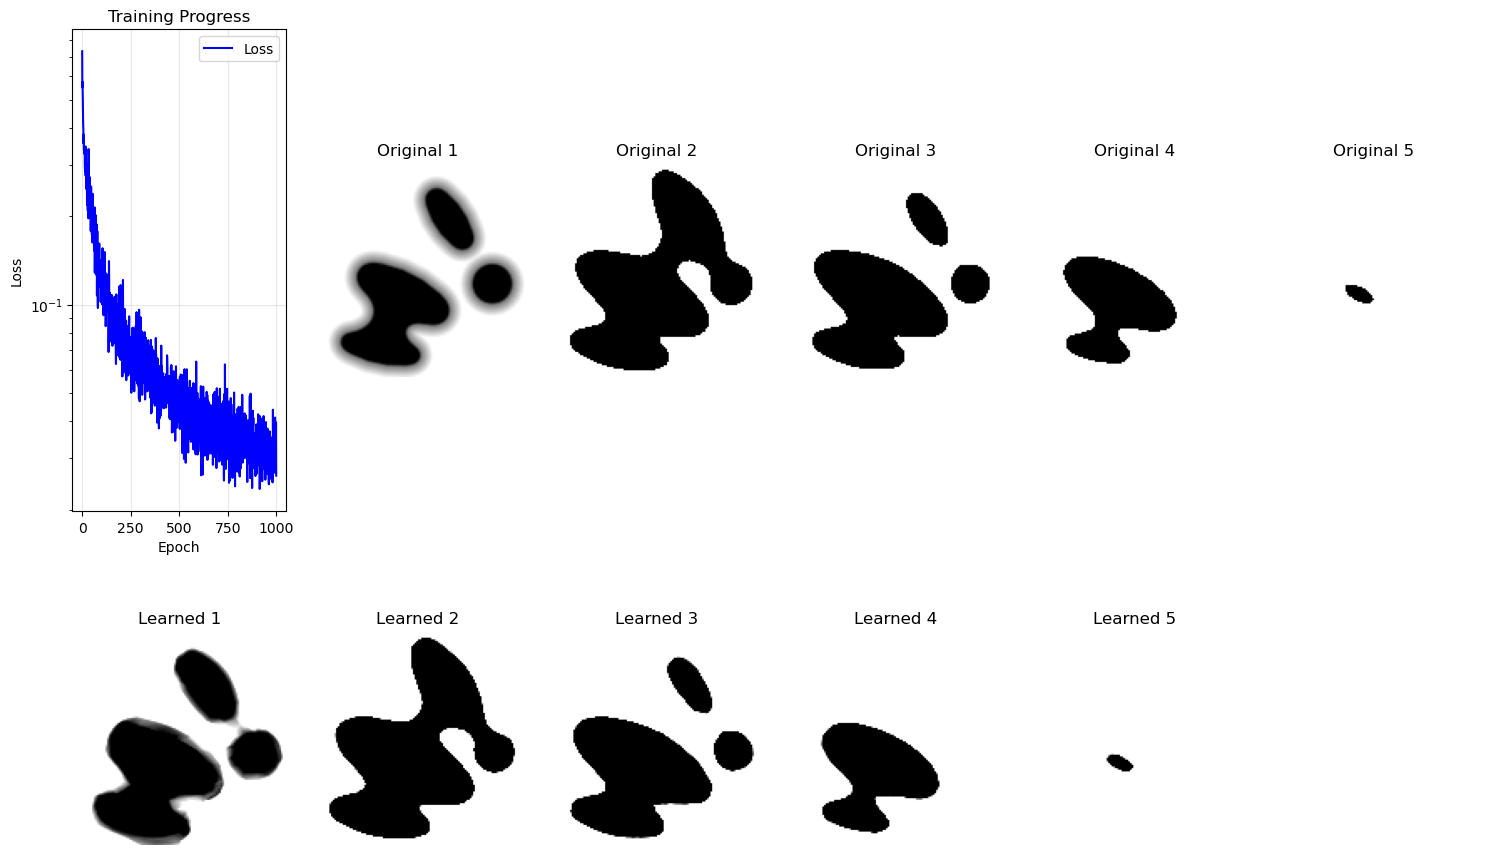

Epoch 1200/2000, Loss: 0.029381


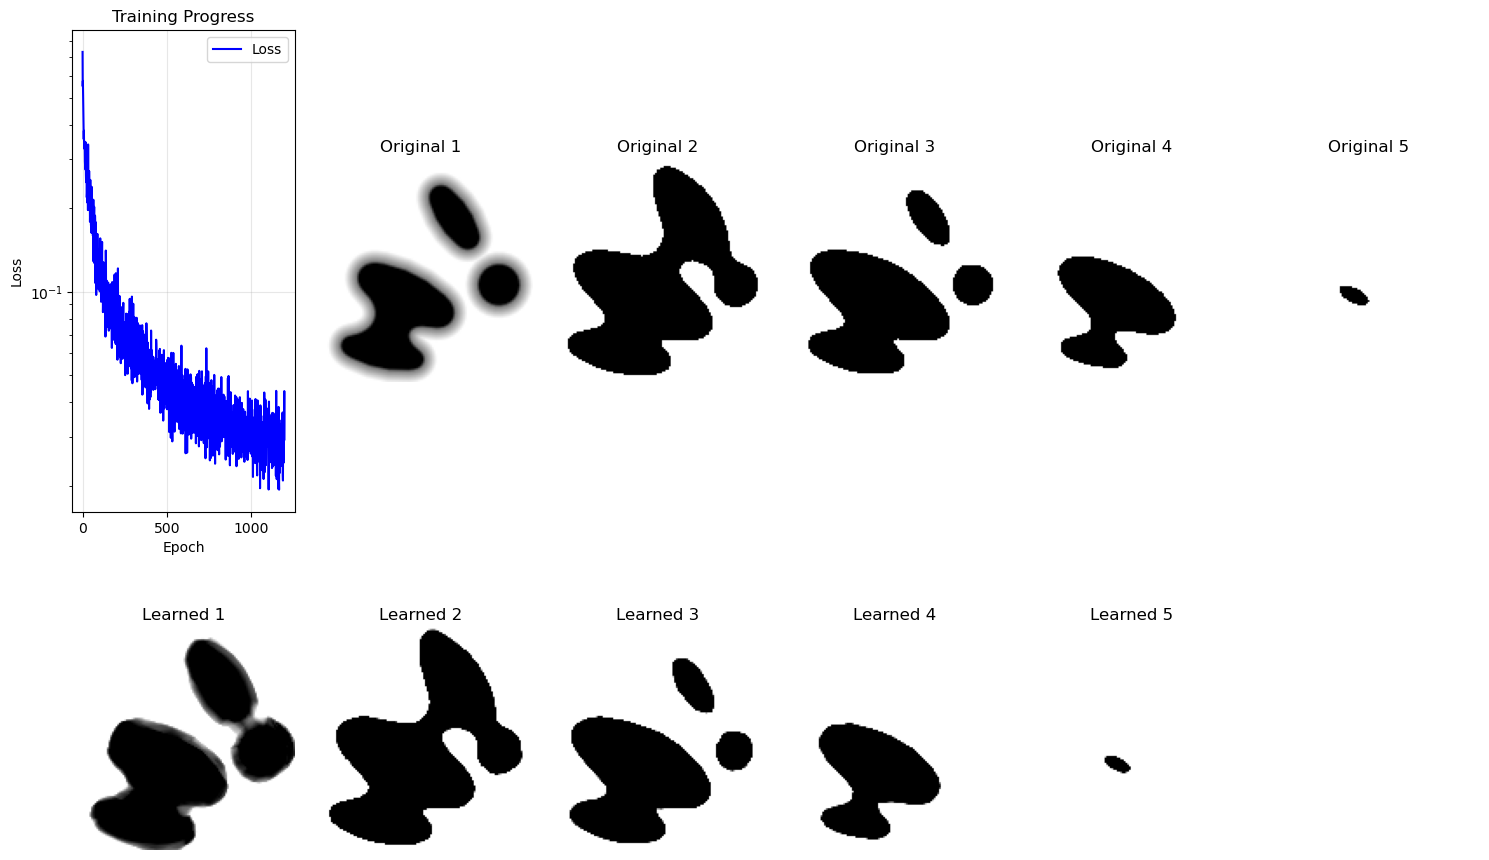

Epoch 1400/2000, Loss: 0.027588


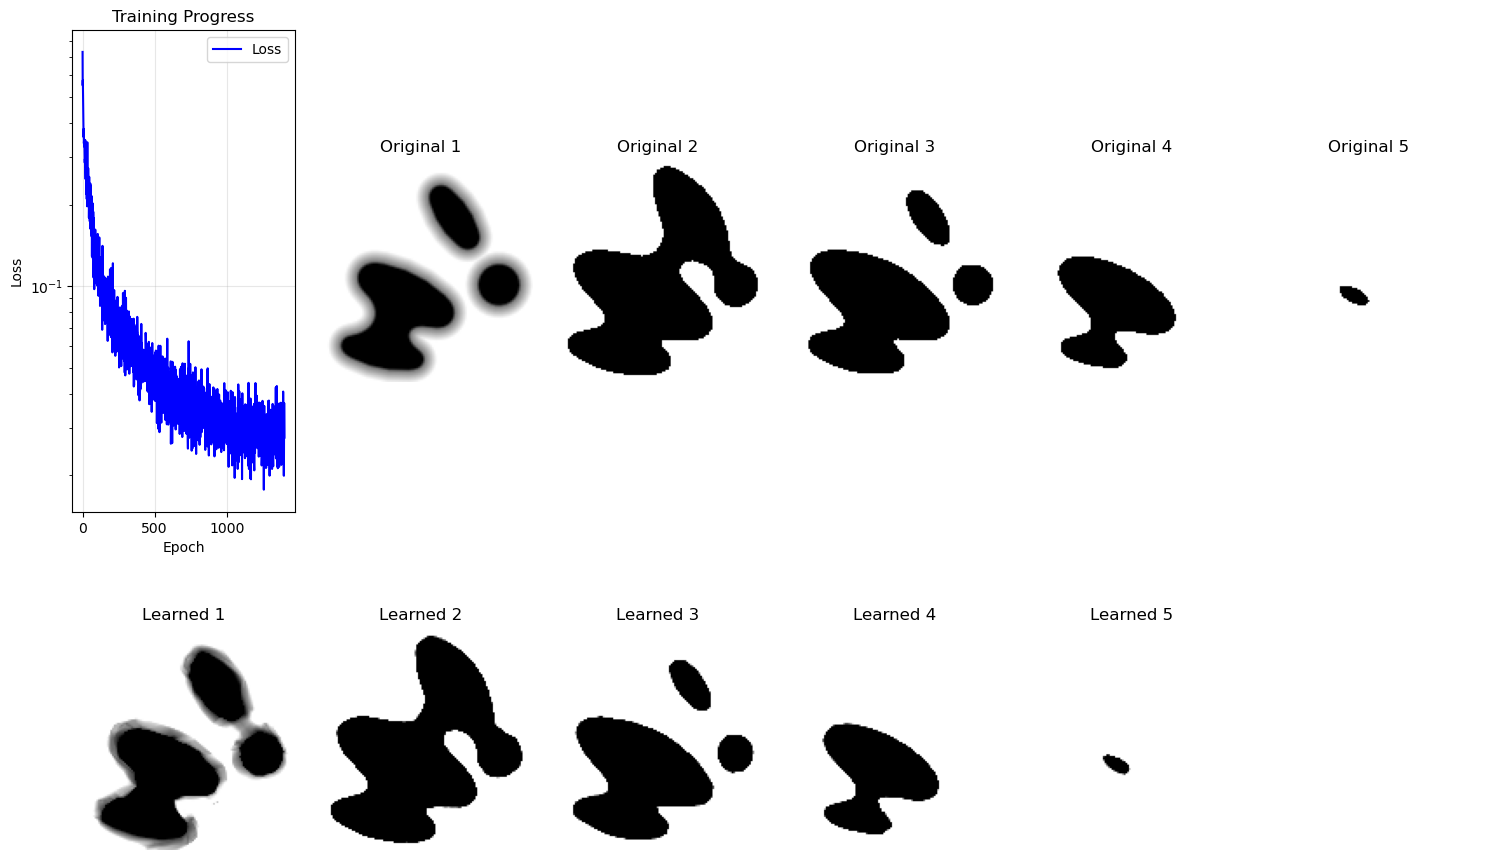

Epoch 1600/2000, Loss: 0.023855


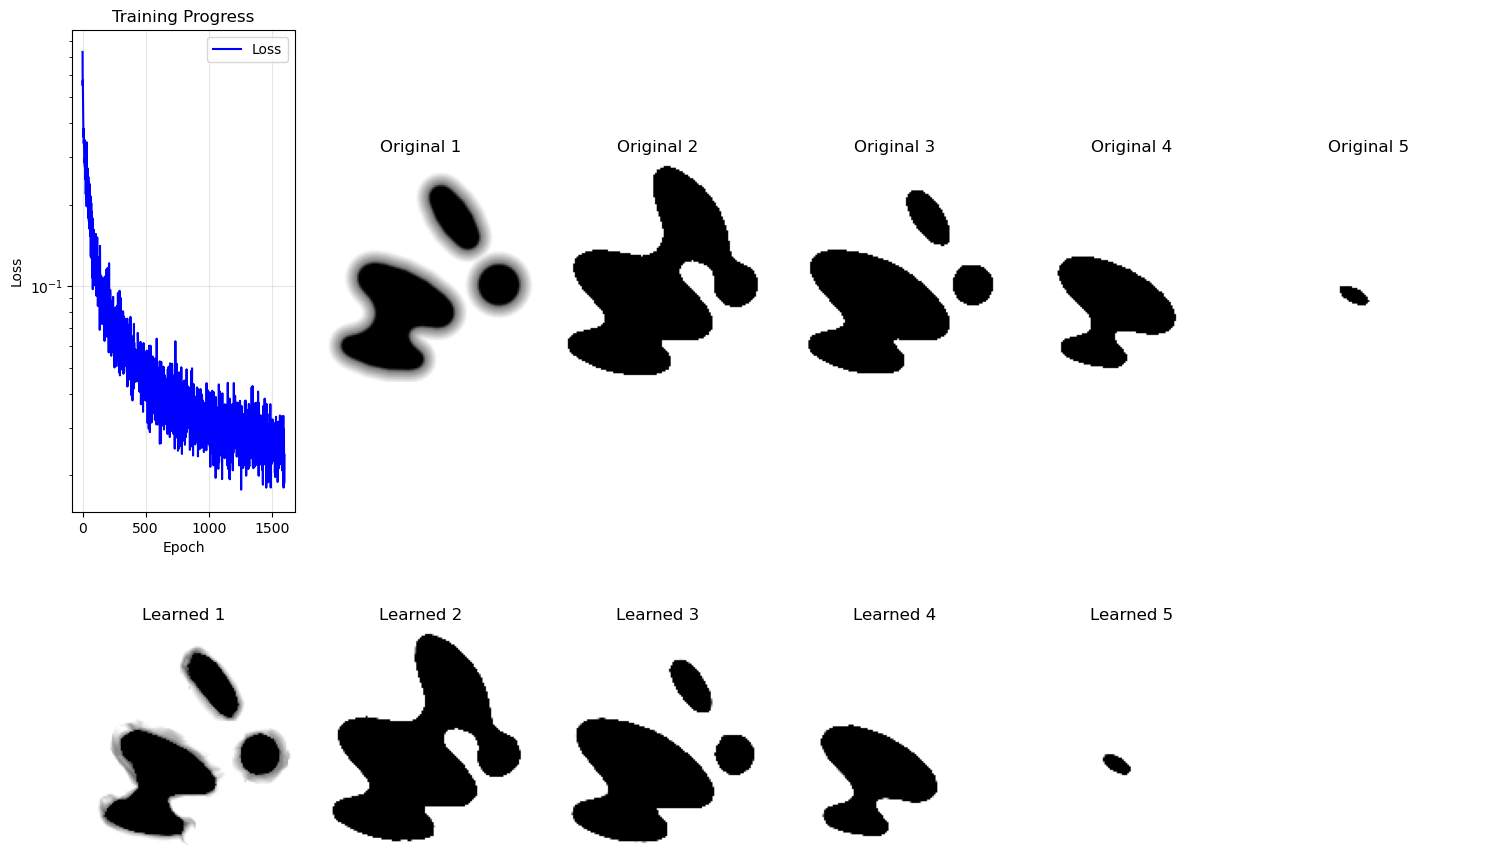

Epoch 1800/2000, Loss: 0.026925


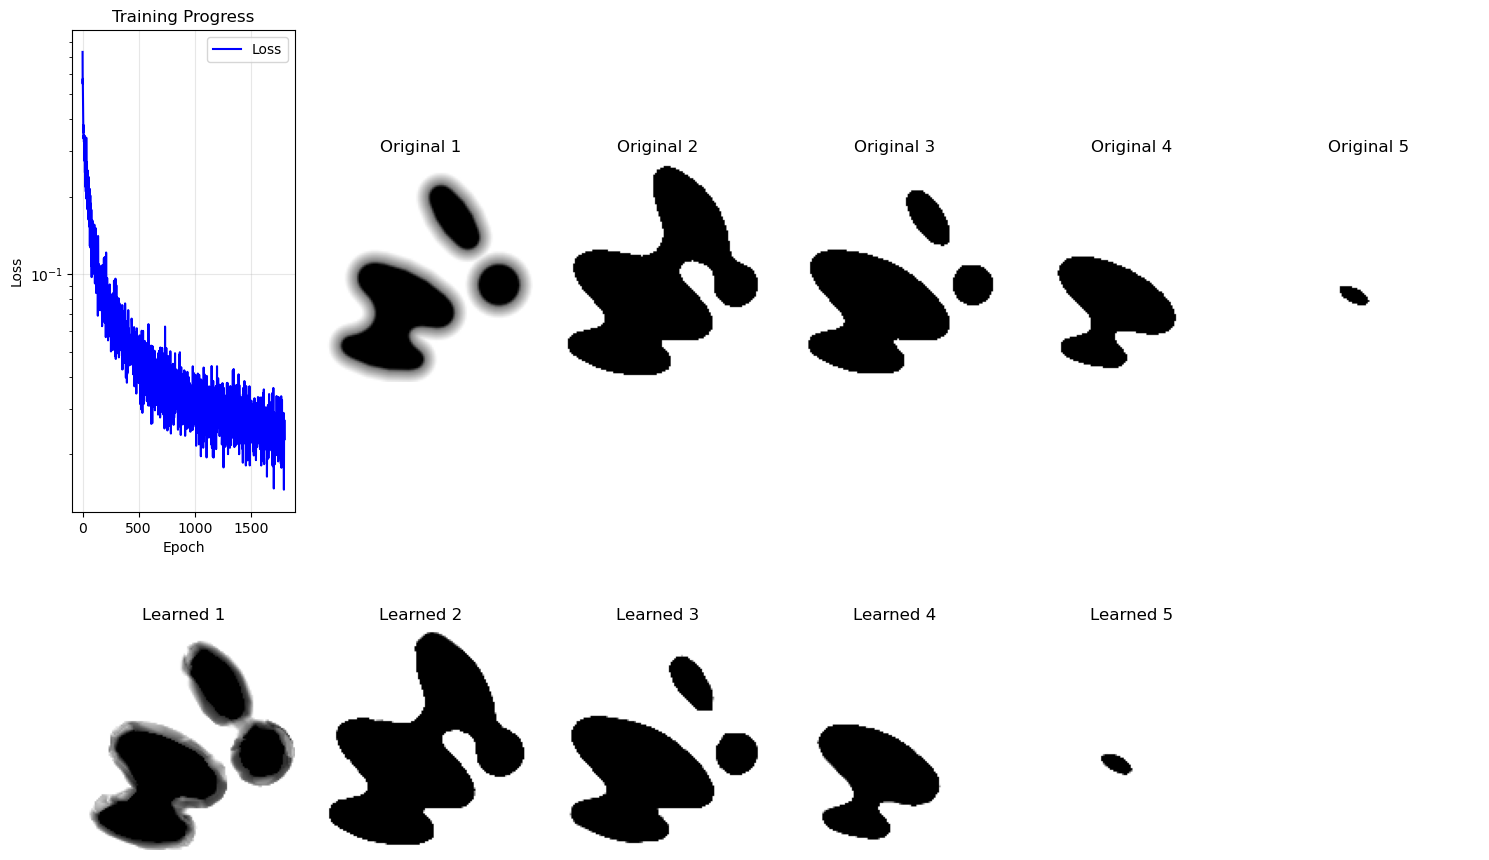

Epoch 2000/2000, Loss: 0.024757


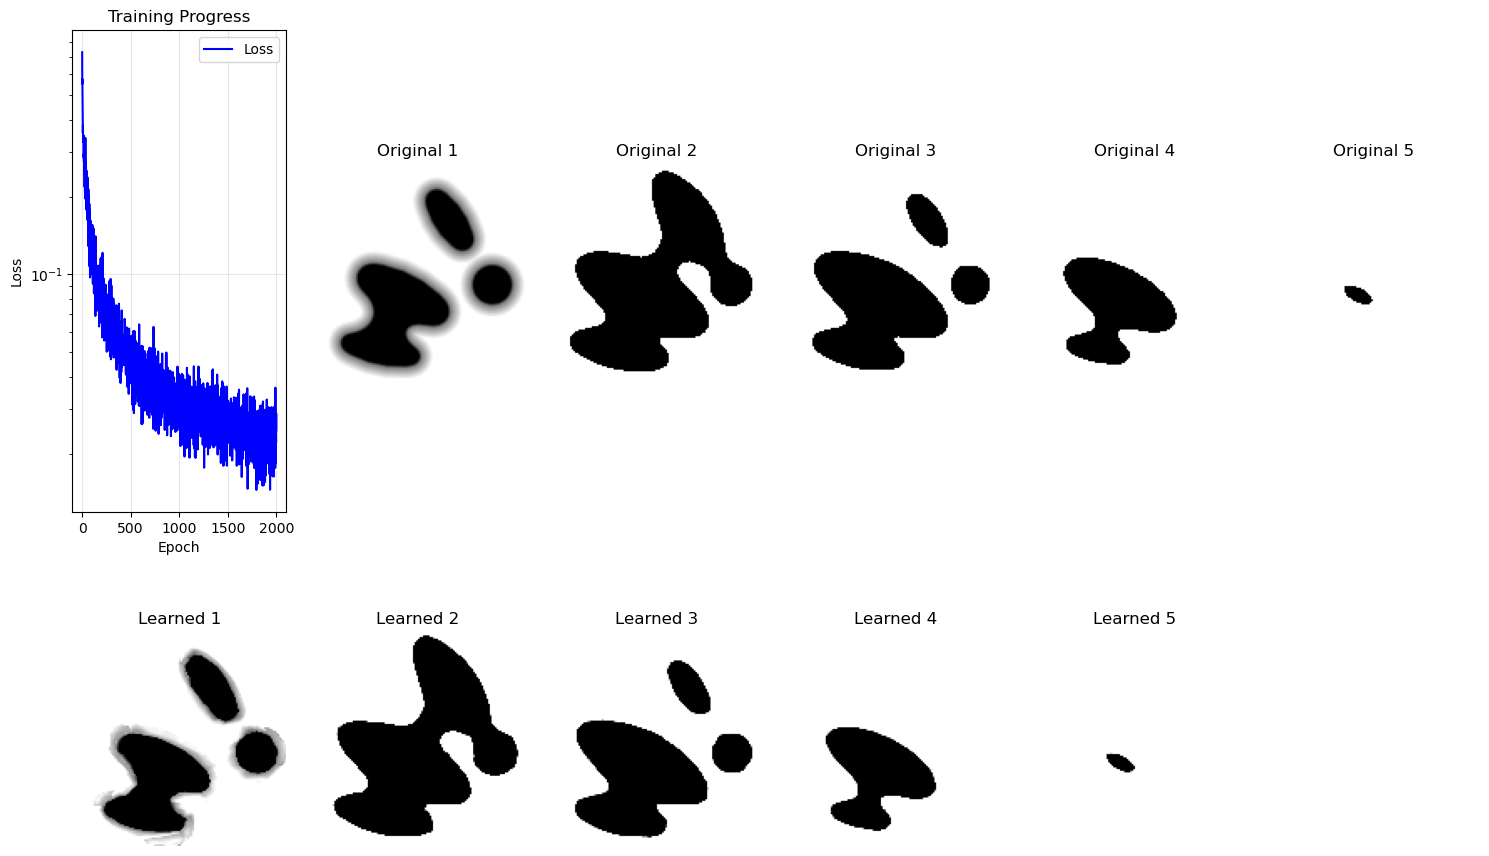

✅ Training complete - latent space learned!


<Figure size 800x400 with 0 Axes>

In [25]:
# Training Loop: Learn latent space representation
print("🎯 Training Auto-Decoder...")

loss_history = []
display_interval = 200

for epoch in range(1, epochs + 1):
    epoch_loss = 0
    num_batches = 0
    
    # Train on each tower shape
    for shape_idx in range(NUM_SHAPES):
        shape_sdf_values = sdf_data_flat[shape_idx]
        
        # Process coordinates in batches
        num_coords = len(coords_flat)
        for batch_start in range(0, num_coords, batch_size):
            batch_end = min(batch_start + batch_size, num_coords)
            
            coord_batch = coords_flat[batch_start:batch_end]
            sdf_batch = shape_sdf_values[batch_start:batch_end]
            
            loss = train_step(shape_idx, coord_batch, sdf_batch)
            epoch_loss += loss
            num_batches += 1
    
    epoch_loss /= num_batches
    loss_history.append(epoch_loss.numpy())
    
    # Show progress and reconstructions
    if epoch % display_interval == 0 or epoch == 1:
        print(f"Epoch {epoch}/{epochs}, Loss: {epoch_loss:.6f}")

        # Visualize learning progress
        plt.figure(figsize=(15, 10))
        
        # Plot training progress
        plt.subplot(2, NUM_SHAPES + 1, 1)
        plt.plot(loss_history, 'b-', label='Loss')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.title('Training Progress')
        plt.yscale('log')
        plt.grid(True, alpha=0.3)
        plt.legend()
        
        # Show reconstructions
        for shape_idx in range(NUM_SHAPES):
            # Generate reconstruction
            shape_latent = latent_codes[shape_idx:shape_idx+1]
            batch_latent_codes = tf.tile(shape_latent, [len(coords_flat), 1])
            decoder_input = tf.concat([batch_latent_codes, coords_flat], axis=1)
            sdf_values = decoder(decoder_input).numpy().flatten()
            reconstructed_sdf = sdf_values.reshape(y_count, x_count)
            
            # Original
            plt.subplot(2, NUM_SHAPES + 1, shape_idx + 2)
            plot_sdf(sdf_data[shape_idx], f"Original {shape_idx+1}")
            
            # Reconstruction  
            plt.subplot(2, NUM_SHAPES + 1, NUM_SHAPES + shape_idx + 2)
            plot_sdf(reconstructed_sdf, f"Learned {shape_idx+1}")
        
        plt.tight_layout()
        plt.show()

# Final training visualization
plt.figure(figsize=(8, 4))

print("✅ Training complete - latent space learned!")

In [26]:
# Compute learned latent space boundaries
learned_latent_codes = latent_codes.numpy()

# Find natural boundaries of the learned space
latent_min_natural = np.min(learned_latent_codes, axis=0)
latent_max_natural = np.max(learned_latent_codes, axis=0)

# Add exploration buffer (20% padding)
buffer_factor = 0.2
buffer = (latent_max_natural - latent_min_natural) * buffer_factor
latent_min_actual = latent_min_natural - buffer
latent_max_actual = latent_max_natural + buffer

print("📊 Learned Latent Space Boundaries:")
print(f"Natural range: [{latent_min_natural[0]:.3f}, {latent_min_natural[1]:.3f}] to [{latent_max_natural[0]:.3f}, {latent_max_natural[1]:.3f}]")
print(f"Exploration range: [{latent_min_actual[0]:.3f}, {latent_min_actual[1]:.3f}] to [{latent_max_actual[0]:.3f}, {latent_max_actual[1]:.3f}]")

📊 Learned Latent Space Boundaries:
Natural range: [-0.205, -0.227] to [0.254, 0.782]
Exploration range: [-0.297, -0.429] to [0.346, 0.984]


## Step 3: Explore the Learned Latent Space

Now we can explore the continuous latent space! Each point in this 2D space corresponds to a potential tower shape. The learned representations allow us to:

- **Interpolate** between existing tower designs
- **Generate** new tower variations
- **Navigate** smoothly through shape space

Learned Tower Positions in Latent Space:
Tower 1: [-0.110, -0.215]
Tower 2: [-0.205, -0.012]
Tower 3: [0.031, 0.143]
Tower 4: [0.254, -0.227]
Tower 5: [0.210, 0.782]


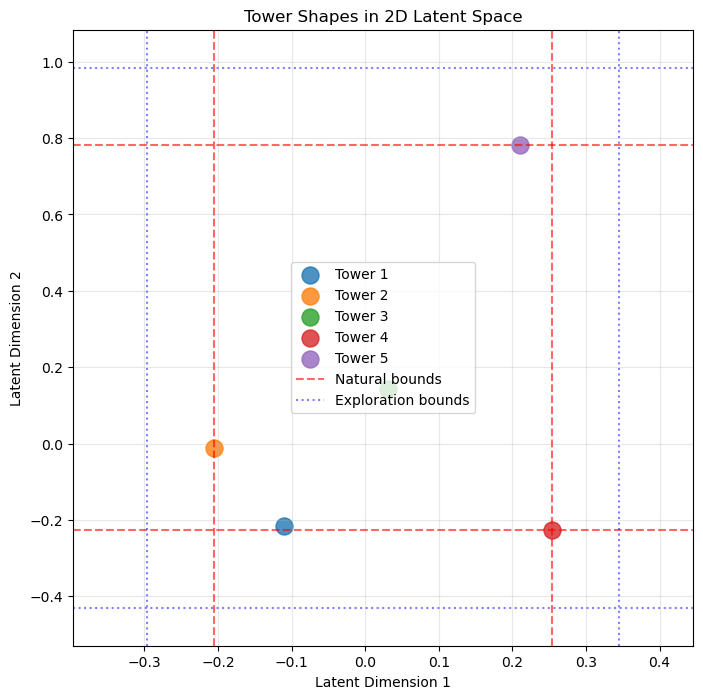

In [27]:
# Visualize learned latent space
learned_latent_codes = latent_codes.numpy()

print("Learned Tower Positions in Latent Space:")
for i, code in enumerate(learned_latent_codes):
    print(f"Tower {i+1}: [{code[0]:.3f}, {code[1]:.3f}]")

# Plot latent space map
plt.figure(figsize=(8, 8))
for i, code in enumerate(learned_latent_codes):
    plt.scatter(code[0], code[1], s=150, label=f"Tower {i+1}", alpha=0.8)

plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2') 
plt.grid(True, alpha=0.3)
plt.legend()
plt.title('Tower Shapes in 2D Latent Space')

# Show exploration boundaries
plt.axhline(y=latent_min_natural[1], color='red', linestyle='--', alpha=0.6, label='Natural bounds')
plt.axhline(y=latent_max_natural[1], color='red', linestyle='--', alpha=0.6)
plt.axvline(x=latent_min_natural[0], color='red', linestyle='--', alpha=0.6)
plt.axvline(x=latent_max_natural[0], color='red', linestyle='--', alpha=0.6)

plt.axhline(y=latent_min_actual[1], color='blue', linestyle=':', alpha=0.5, label='Exploration bounds')
plt.axhline(y=latent_max_actual[1], color='blue', linestyle=':', alpha=0.5)
plt.axvline(x=latent_min_actual[0], color='blue', linestyle=':', alpha=0.5)
plt.axvline(x=latent_max_actual[0], color='blue', linestyle=':', alpha=0.5)

plt.xlim(latent_min_actual[0] - 0.1, latent_max_actual[0] + 0.1)
plt.ylim(latent_min_actual[1] - 0.1, latent_max_actual[1] + 0.1)
plt.legend()
plt.show()

🗼 Generating Tower Variations Across Latent Space...


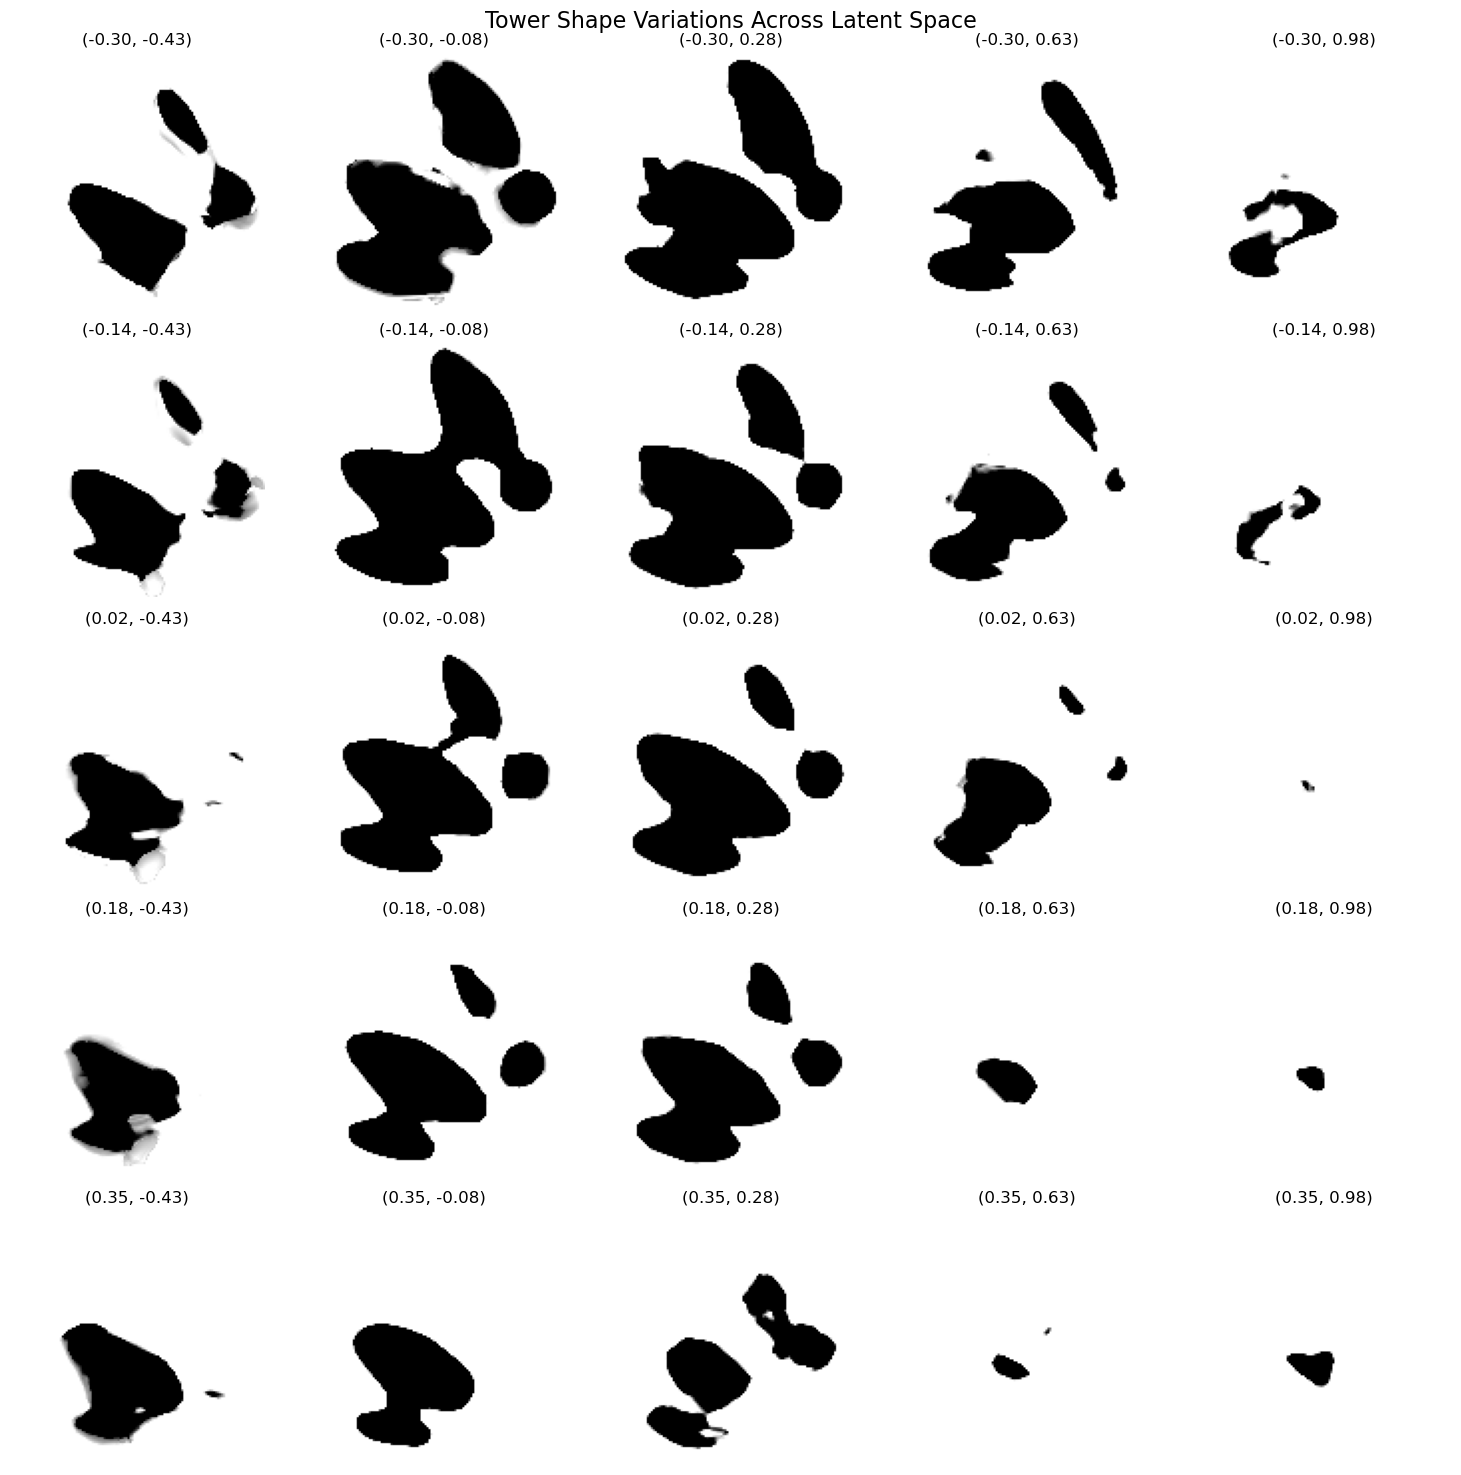

✨ Notice how shapes transition smoothly across the latent space!


In [28]:
# Generate new tower shapes by sampling from latent space
def generate_sdf_from_latent(latent_code):
    """Generate tower SDF from latent coordinates"""
    if len(latent_code.shape) == 1:
        latent_code = latent_code[np.newaxis, :]
    latent_code_f32 = tf.cast(latent_code, tf.float32)
    
    # Ensure within exploration bounds
    latent_code_clamped = tf.clip_by_value(latent_code_f32, latent_min_actual, latent_max_actual)
    
    # Generate full SDF by querying all spatial coordinates
    num_coords = coords_flat.shape[0]
    batch_latent_codes = tf.tile(latent_code_clamped, [num_coords, 1])
    decoder_input = tf.concat([batch_latent_codes, coords_flat], axis=1)
    sdf_values = decoder(decoder_input).numpy().flatten()
    
    # Reshape to 2D grid
    sdf = sdf_values.reshape(y_count, x_count)
    return sdf

# Sample grid of latent space to see shape variations
print("🗼 Generating Tower Variations Across Latent Space...")

grid_size = 5
plt.figure(figsize=(15, 15))

for i in range(grid_size):
    for j in range(grid_size):
        # Create grid coordinates within exploration range
        latent_x = latent_min_actual[0] + (latent_max_actual[0] - latent_min_actual[0]) * i / (grid_size - 1)
        latent_y = latent_min_actual[1] + (latent_max_actual[1] - latent_min_actual[1]) * j / (grid_size - 1)
        
        # Generate tower at this latent position
        latent_point = np.array([latent_x, latent_y])
        tower_sdf = generate_sdf_from_latent(latent_point[np.newaxis, :])
        
        # Visualize
        plt.subplot(grid_size, grid_size, i * grid_size + j + 1)
        plot_sdf(tower_sdf, f'({latent_x:.2f}, {latent_y:.2f})')

plt.suptitle('Tower Shape Variations Across Latent Space', fontsize=16)
plt.tight_layout()
plt.show()

print("✨ Notice how shapes transition smoothly across the latent space!")

## Step 4: Export for Interactive Path Creation

Export the trained model for use with the **PathSelect** application, which allows you to:

🎯 **Create custom paths** by clicking points in the latent space  
🎬 **Generate smooth animations** along your designed paths  
💾 **Export SDF sequences** for further use  

The PathSelect app provides an interactive interface to explore the learned latent space visually.

In [29]:
# Export trained model for PathSelect interactive application
import shutil
def export_model_package(output_folder="models"):
    """Export complete auto-decoder package for interactive exploration"""
    
    if os.path.exists(output_folder):
        shutil.rmtree(output_folder)
    os.makedirs(output_folder, exist_ok=True)

    # 1. Save trained decoder network
    decoder_path = os.path.join(output_folder, "decoder_model.h5")
    decoder.save(decoder_path)
    print(f"✅ Decoder network saved")
    
    # 2. Save learned latent codes
    latent_codes_path = os.path.join(output_folder, "latent_codes.npy")
    np.save(latent_codes_path, latent_codes.numpy())
    print(f"✅ Latent codes saved")
    
    # 3. Save coordinate grid  
    coords_path = os.path.join(output_folder, "coords_flat.npy")
    np.save(coords_path, coords_flat)
    print(f"✅ Coordinate grid saved")
    
    # 4. Save latent space boundaries
    latent_range_path = os.path.join(output_folder, "latent_range.npy")
    range_info = {
        'latent_min_natural': latent_min_natural.tolist(),
        'latent_max_natural': latent_max_natural.tolist(),
        'latent_min_actual': latent_min_actual.tolist(),
        'latent_max_actual': latent_max_actual.tolist(),
        'buffer_factor': buffer_factor
    }
    np.save(latent_range_path, range_info)
    print(f"✅ Latent space bounds saved")
    
    # 5. Create enhanced metadata
    enhanced_data = {}
    
    # Load original data if available
    if os.path.exists("data.json"):
        with open("data.json", "r") as f:
            enhanced_data = json.load(f)
    else:
        enhanced_data = {
            'scalar_field_XCount': [x_count],
            'scalar_field_YCount': [y_count],
            'scalar_field_XSize': [2.0],
            'scalar_field_YSize': [2.0]
        }
    
    # Add model metadata
    enhanced_data['model_metadata'] = {
        'latent_dim': LATENT_DIM,
        'num_shapes': NUM_SHAPES,
        'training_epochs': epochs,
        'grid_size': {'x': int(x_count), 'y': int(y_count)},
        'latent_range': {
            'natural_min': latent_min_natural.tolist(),
            'natural_max': latent_max_natural.tolist(), 
            'exploration_min': latent_min_actual.tolist(),
            'exploration_max': latent_max_actual.tolist(),
            'normalization_type': 'natural_range'
        },
        'export_timestamp': datetime.now().isoformat()
    }
    
    # Save enhanced data
    enhanced_data_path = os.path.join(output_folder, "data.json")
    with open(enhanced_data_path, 'w') as f:
        json.dump(enhanced_data, f, indent=2)
    print(f"✅ Model metadata saved")
    
    print(f"\n🎉 Model package exported to '{output_folder}/' folder!")
    print("📂 Contents:")
    for filename in os.listdir(output_folder):
        print(f"   • {filename}")
    
    print(f"\n🚀 Ready for PathSelect interactive exploration!")

# Export the trained model
export_model_package()

✅ Decoder network saved
✅ Latent codes saved
✅ Coordinate grid saved
✅ Latent space bounds saved
✅ Model metadata saved

🎉 Model package exported to 'models/' folder!
📂 Contents:
   • coords_flat.npy
   • data.json
   • decoder_model.h5
   • latent_codes.npy
   • latent_range.npy

🚀 Ready for PathSelect interactive exploration!
